In [26]:
import os
from math import pi
from typing import Callable, Tuple

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d


Array = np.ndarray

In [16]:
# SI units
G = 6.67408e-11  # m^3 s^-2 kg^-1
C = 299792458.0  # m/s
MSUN = 1.98855e30  # kg
PC = 3.08567758149137e16  # m
YR = 365.25 * 24 * 3600  # s
# LISA parameters
# https://www.elisascience.org/files/publications/LISA_L3_20170120.pdf
t = 4.0  # LISA lifetime (sec. 3.4)
dt = 1 / 3.33  # LISA sampling rate [Hz] (sec. 5.4.2)


def get_r_isco(m_1):
    return 6 * G * m_1 / C ** 2


def get_f_isco(m_1):
    return np.sqrt(G * m_1 / get_r_isco(m_1) ** 3) / pi


def load_strains(
    fname: str, m_1: float, m_2: float
) -> Tuple[
    Callable[[Array, float, float, float], Array],
    Callable[[Array, float, float, float], Array],
]:
    """
    Loads strain interpolators.

    Notes:
        See https://arxiv.org/abs/1408.3534, eqs. 21 - 22

    Args:
        m_1: mass of IMBH [kg]
        m_2: mass of compact object [kg]

    Returns:
        hp_t, hc_t: functions to compute the time-domain plus and cross strains.
        Their arguments are:
        - t: time relative to merger [s]
        - d_l: luminosity distance to binary [m]
        - iota: inclination angle [rad]
        - phi_c: phase at coalescence [rad]
    """
    _ts, _fs = np.loadtxt(fname, unpack=True, usecols=(0, 2))
    _fs *= 2  # GW frequency
    _ts = _ts - _ts[-1]  # time to merger

    f_isco = get_f_isco(m_1)
    if _fs[-1] < f_isco:
        warnings.warn("waveform doesn't extend to ISCO")

    # Interpolate waveform data
    omega_gw = interp1d(_ts, 2 * pi * _fs)  # f_gw -> omega_gw
    omega_orb = interp1d(_ts, 2 * pi * (_fs / 2))  # f_gw -> omega_orb
    _rs = (G * (m_1 + m_2) / (pi * _fs) ** 2) ** (1 / 3)  # f -> r
    r = interp1d(_ts, _rs)

    # Strain functions
    def h0(t):
        return 4 * G * m_2 * omega_orb(t) ** 2 * r(t) ** 2 / C ** 4

    def hp_t(t: Array, d_l: float, iota: float, phi_c: float = 0) -> Array:
        return (
            1
            / d_l
            * h0(t)
            * (1 + np.cos(iota) ** 2)
            / 2
            * np.cos(omega_gw(t) * t + phi_c)
        )

    def hc_t(t: Array, d_l: float, iota: float, phi_c: float = 0) -> Array:
        return 1 / d_l * h0(t) * np.cos(iota) * np.sin(omega_gw(t) * t + phi_c)

    return hp_t, hc_t, omega_gw

In [17]:
run_dir = "/Users/acoogan/Physics/dark_dress/finalRuns/full/"  # <-- CHANGE!
# Parameters
m_1 = 1e3 * MSUN
m_2 = 1 * MSUN
rho = 20
gamma_s = 2.3333
d_L = 1e6 * PC
iota = 0
phi_c = 0
ts = np.linspace(-4 * YR, -0 * YR, 10000)
print(f"Timestep: {ts[1] - ts[0]}")

# Don't change this
id_str = f"M1_{m_1 / MSUN:.1f}_M2_{m_2 / MSUN:.1f}_rho_{rho:g}_gamma_{gamma_s:.4f}"
fname = os.path.join(run_dir, id_str, f"output_dynamic_dress_{id_str}.dat")
hp_t, hc_t, omega_gw = load_strains(fname, m_1, m_2)

Timestep: 12624.3024302423


(-100000100.0, -100000000.0)

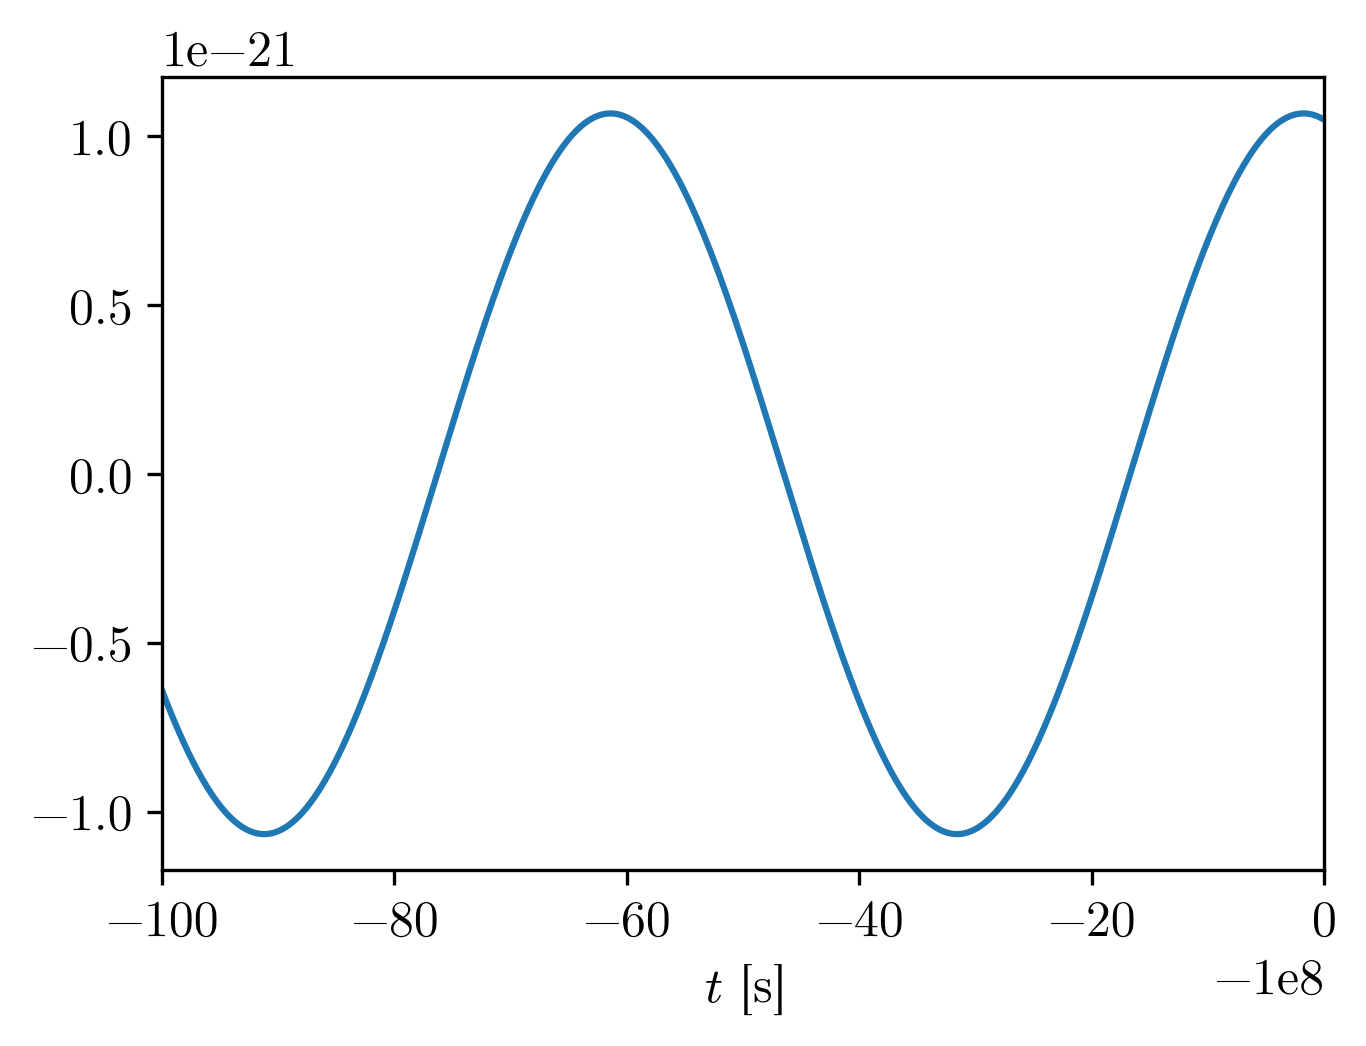

In [51]:
ts = np.linspace(-1.000001e8, -1e8, 1000)
plt.plot(ts, hp_t(ts, d_L, iota, phi_c))
plt.xlabel(r"$t$ [s]")
plt.xlim(ts[[0, -1]])